In [4]:
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd
from videpy import Vide

import networkx as nx
# from causalgraphicalmodels import CausalGraphicalModel

import stan
import nest_asyncio

plt.style.use('default')

plt.rcParams['axes.facecolor'] = 'lightgray'

# To DAG's
import daft
from causalgraphicalmodels import CausalGraphicalModel

In [5]:
# To running the stan in jupyter notebook
nest_asyncio.apply()

### R Code 7.1 - Pag 194

In [6]:
sppnames = ('afarensis', 'africanus', 'habilis',  'boisei', 'rudolfensis', 'ergaster', 'sapiens')
brainvolcc = (438, 452, 612, 521,  752, 871, 1350)
masskg = (37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5)

d = pd.DataFrame({'species':sppnames, 'brain': brainvolcc, 'mass':masskg})
d

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


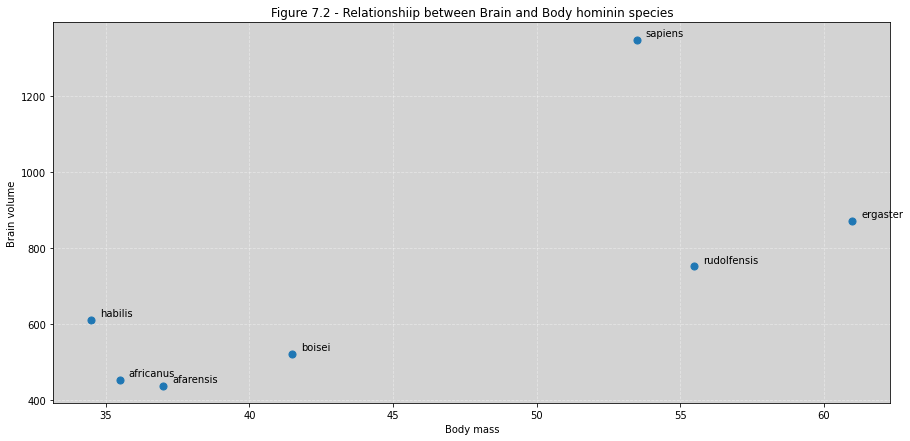

In [7]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(d.mass, d.brain, marker='o', s=50)

for i, text in enumerate(sppnames):
    ax.annotate(text, (d.mass[i]+0.3, d.brain[i]+10))
    
ax.set_title('Figure 7.2 - Relationshiip between Brain and Body hominin species')
ax.set_xlabel('Body mass')
ax.set_ylabel('Brain volume')

ax.grid(ls='--', color='white', alpha=0.4)
plt.show()

### R Code 7.2 - pag 196

In [8]:
np.std(d.mass, ddof=1)

10.90489186863706

In [9]:
d.mass.std()

10.90489186863706

In [10]:
d['mass_std'] = (d.mass - d.mass.mean())/d.mass.std()
d['brain_std'] = d.brain / np.max(d.brain)
d

,species,brain,mass,mass_std,brain_std
0,afarensis,438,37.0,-0.779467,0.324444
1,africanus,452,35.5,-0.917020,0.334815
2,habilis,612,34.5,-1.008722,0.453333
3,boisei,521,41.5,-0.366808,0.385926
4,rudolfensis,752,55.5,0.917020,0.557037
5,ergaster,871,61.0,1.421380,0.645185
6,sapiens,1350,53.5,0.733616,1.000000


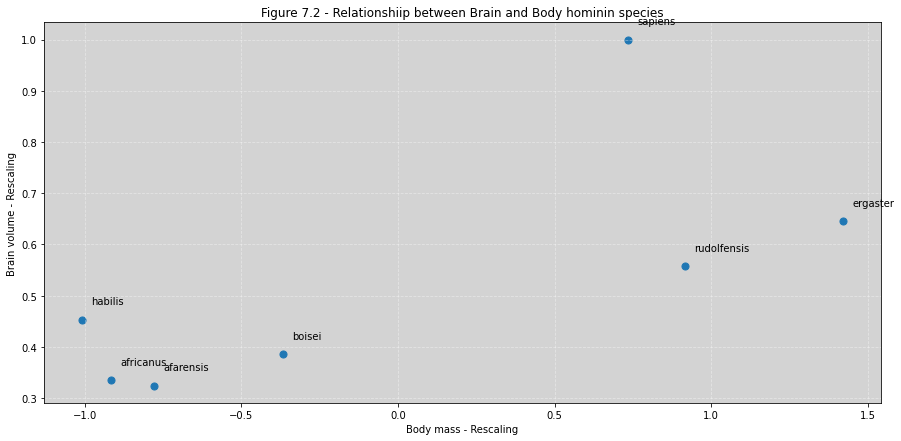

In [11]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(d.mass_std, d.brain_std, marker='o', s=50)

for i, text in enumerate(sppnames):
    ax.annotate(text, (d.mass_std[i]+0.03, d.brain_std[i]+0.03))
    
ax.set_title('Figure 7.2 - Relationshiip between Brain and Body hominin species')
ax.set_xlabel('Body mass - Rescaling')
ax.set_ylabel('Brain volume - Rescaling')

ax.grid(ls='--', color='white', alpha=0.4)
plt.show()

### R Code 7.3 - pag 196

Modelo linear:

$\begin{align}
b_i \sim Normal(\mu_i, \sigma) \\ 
\mu_i = \alpha + \beta m_i \\
\alpha \sim Normal(0.5, 1) \\
\beta \sim Normal(0, 10) \\
\sigma \sim LogNormal(0, 1) \\
\end{align}$





In [9]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta;
        real<lower=0> sigma;
        // real log_sigma;  // Like the book
    }
    
    model {
        vector[N] mu;
        
        mu = alpha + beta * body;
                
        // Prioris
        alpha ~ normal(0.5, 1);
        beta ~ normal(0, 10);
        sigma ~ lognormal(0, 1);
        // log_sigma ~ normal(0, 1);  // Like the book 
        
        // Likelihood
        brain ~ normal(mu, sigma);
        // brain ~ normal(mu, exp(sigma));  // Like the book
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_1 = stan.build(model, data=data)
samples_1 = posteriori_1.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!


In [10]:
Vide.summary(samples_1)

,mean,std,7.0%,93.0%
alpha,0.53,0.11,0.32,0.73
beta,0.17,0.13,-0.05,0.39
sigma,0.27,0.13,0.11,0.47


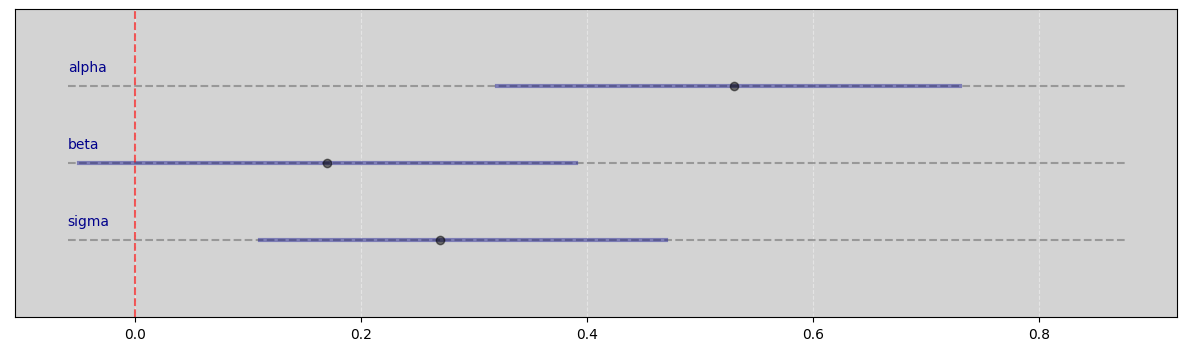

In [11]:
Vide.plot_forest(samples_1)

### R Code 7.4 - pag 196

Just example code in R

`m7.1_OLS <- lm(brain_std ~ brain_std, data=d)`

### R Code 7.5 - pag 197

In [12]:
def var2(x):
    return np.sum(np.power(x - np.mean(x), 2))/len(x)

In [13]:
mean_std = [np.mean((samples_1['alpha'].flatten() + samples_1['beta'].flatten() * mass)) for mass in d.mass_std.values]
r = mean_std - d.brain_std

resid_var = var2(r)
outcome_var = var2(d.brain_std)

1 - resid_var/outcome_var

0.4901532718125907

### R Code 7.6 - Pag 197

In [14]:
def R2_is_bad():
    pass

### R Code 7.7 - pag 198

In [15]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[2];
        real<lower=0> sigma;
    }
    
    model {
        vector[N] mu;
        
        mu = alpha + beta[1] * body + beta[2] * body^2;
        
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:2){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 1);    
        
        // Likelihood
        brain ~ normal(mu, sigma);
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_2 = stan.build(model, data=data)
samples_2 = posteriori_2.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!


In [16]:
Vide.summary(samples_2)

,mean,std,7.0%,93.0%
alpha,0.59,0.26,0.10,1.03
beta[0],0.19,0.16,-0.09,0.51
beta[1],-0.07,0.27,-0.50,0.44
sigma,0.31,0.15,0.11,0.55


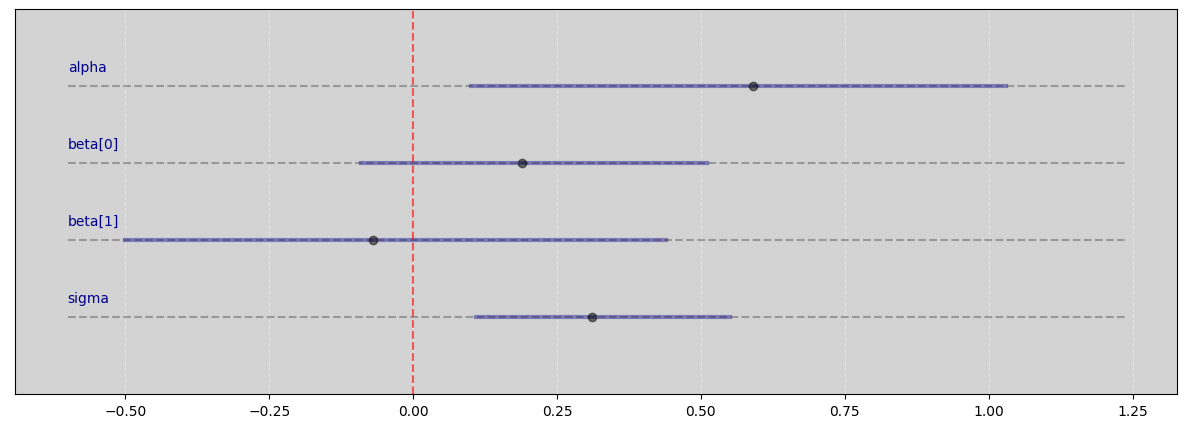

In [17]:
Vide.plot_forest(samples_2)

### R Code 7.8 - Pag 198

In [18]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[3];
        real<lower=0> sigma;
    }
    
    model {
        vector[N] mu;
        
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3;
                     
        // Likelihood
        brain ~ normal(mu, sigma);
        
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:3){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 1);    
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_3 = stan.build(model, data=data)
samples_3 = posteriori_3.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!


In [19]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[4];
        real<lower=0> sigma;
    }
    
    model {
        vector[N] mu;
        
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3 +
                     beta[4] * body^4;
                     
        // Likelihood
        brain ~ normal(mu, sigma);
        
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:4){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 1);    
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_4 = stan.build(model, data=data)
samples_4 = posteriori_4.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!


In [20]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[5];
        real<lower=0> sigma;
    }
    
    model {
        vector[N] mu;
        
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3 +
                     beta[4] * body^4 +
                     beta[5] * body^5;
                     
        // Likelihood
        brain ~ normal(mu, sigma);
        
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:5){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 1);    
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_5 = stan.build(model, data=data)
samples_5 = posteriori_5.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:   4% (300/8000)
Sampling:   9% (700/8000)
Sampling:  14% (1100/8000)
Sampling:  20% (1600/8000)
Sampling:  41% (3300/8000)
Sampling:  61% (4900/8000)
Sampling:  81% (6500/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!


### R Code 7.9 - Pag 199

In [21]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[6];
    }
    
    model {
        vector[N] mu;
        
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3 +
                     beta[4] * body^4 +
                     beta[5] * body^5 +
                     beta[6] * body^6;
                     
        // Likelihood
        brain ~ normal(mu, 0.001);
        
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:6){
            beta[j] ~ normal(0, 10);
        }    
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_6 = stan.build(model, data=data)
samples_6 = posteriori_6.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_07foxu_h/model_dq2btk6b.stan', line 24, column 27: Argument 0.001 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   8% (600/8000)
Sampling:  14% (1100/8000)
Sampling:  21% (1700/8000)
Sampling:  26% (2100/8000)
Sampling:  44% (3500/8000)
Sampling:  62% (5000/8000)
Sampling:  80% (6400/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition 

### R Code 7.10 - Pag 199

In [22]:
mass_seq = np.linspace(start=d.mass_std.min(), stop=d.mass_std.max(), num=100)

In [23]:
pp_1 = [samples_1['alpha'].flatten() + samples_1['beta'].flatten() * mass_i for mass_i in mass_seq]

In [24]:
pp_2 = [samples_2['alpha'].flatten() + 
        samples_2['beta'][0].flatten() * mass_i + 
        samples_2['beta'][1].flatten() * np.power(mass_i, 2) for mass_i in mass_seq]

In [25]:
pp_3 = [samples_3['alpha'].flatten() + 
        samples_3['beta'][0].flatten() * mass_i + 
        samples_3['beta'][1].flatten() * np.power(mass_i, 2) + 
        samples_3['beta'][2].flatten() * np.power(mass_i, 3)
        for mass_i in mass_seq]

In [26]:
pp_4 = [samples_4['alpha'].flatten() + 
        samples_4['beta'][0].flatten() * mass_i + 
        samples_4['beta'][1].flatten() * np.power(mass_i, 2) + 
        samples_4['beta'][2].flatten() * np.power(mass_i, 3) +
        samples_4['beta'][3].flatten() * np.power(mass_i, 4) 
        for mass_i in mass_seq]

In [27]:
pp_5 = [samples_5['alpha'].flatten() + 
        samples_5['beta'][0].flatten() * mass_i + 
        samples_5['beta'][1].flatten() * np.power(mass_i, 2) + 
        samples_5['beta'][2].flatten() * np.power(mass_i, 3) +
        samples_5['beta'][3].flatten() * np.power(mass_i, 4) + 
        samples_5['beta'][4].flatten() * np.power(mass_i, 5) 
        for mass_i in mass_seq]

In [28]:
pp_6 = [samples_6['alpha'].flatten() + 
        samples_6['beta'][0].flatten() * mass_i + 
        samples_6['beta'][1].flatten() * np.power(mass_i, 2) + 
        samples_6['beta'][2].flatten() * np.power(mass_i, 3) +
        samples_6['beta'][3].flatten() * np.power(mass_i, 4) + 
        samples_6['beta'][4].flatten() * np.power(mass_i, 5) + 
        samples_6['beta'][5].flatten() * np.power(mass_i, 6) 
        for mass_i in mass_seq]

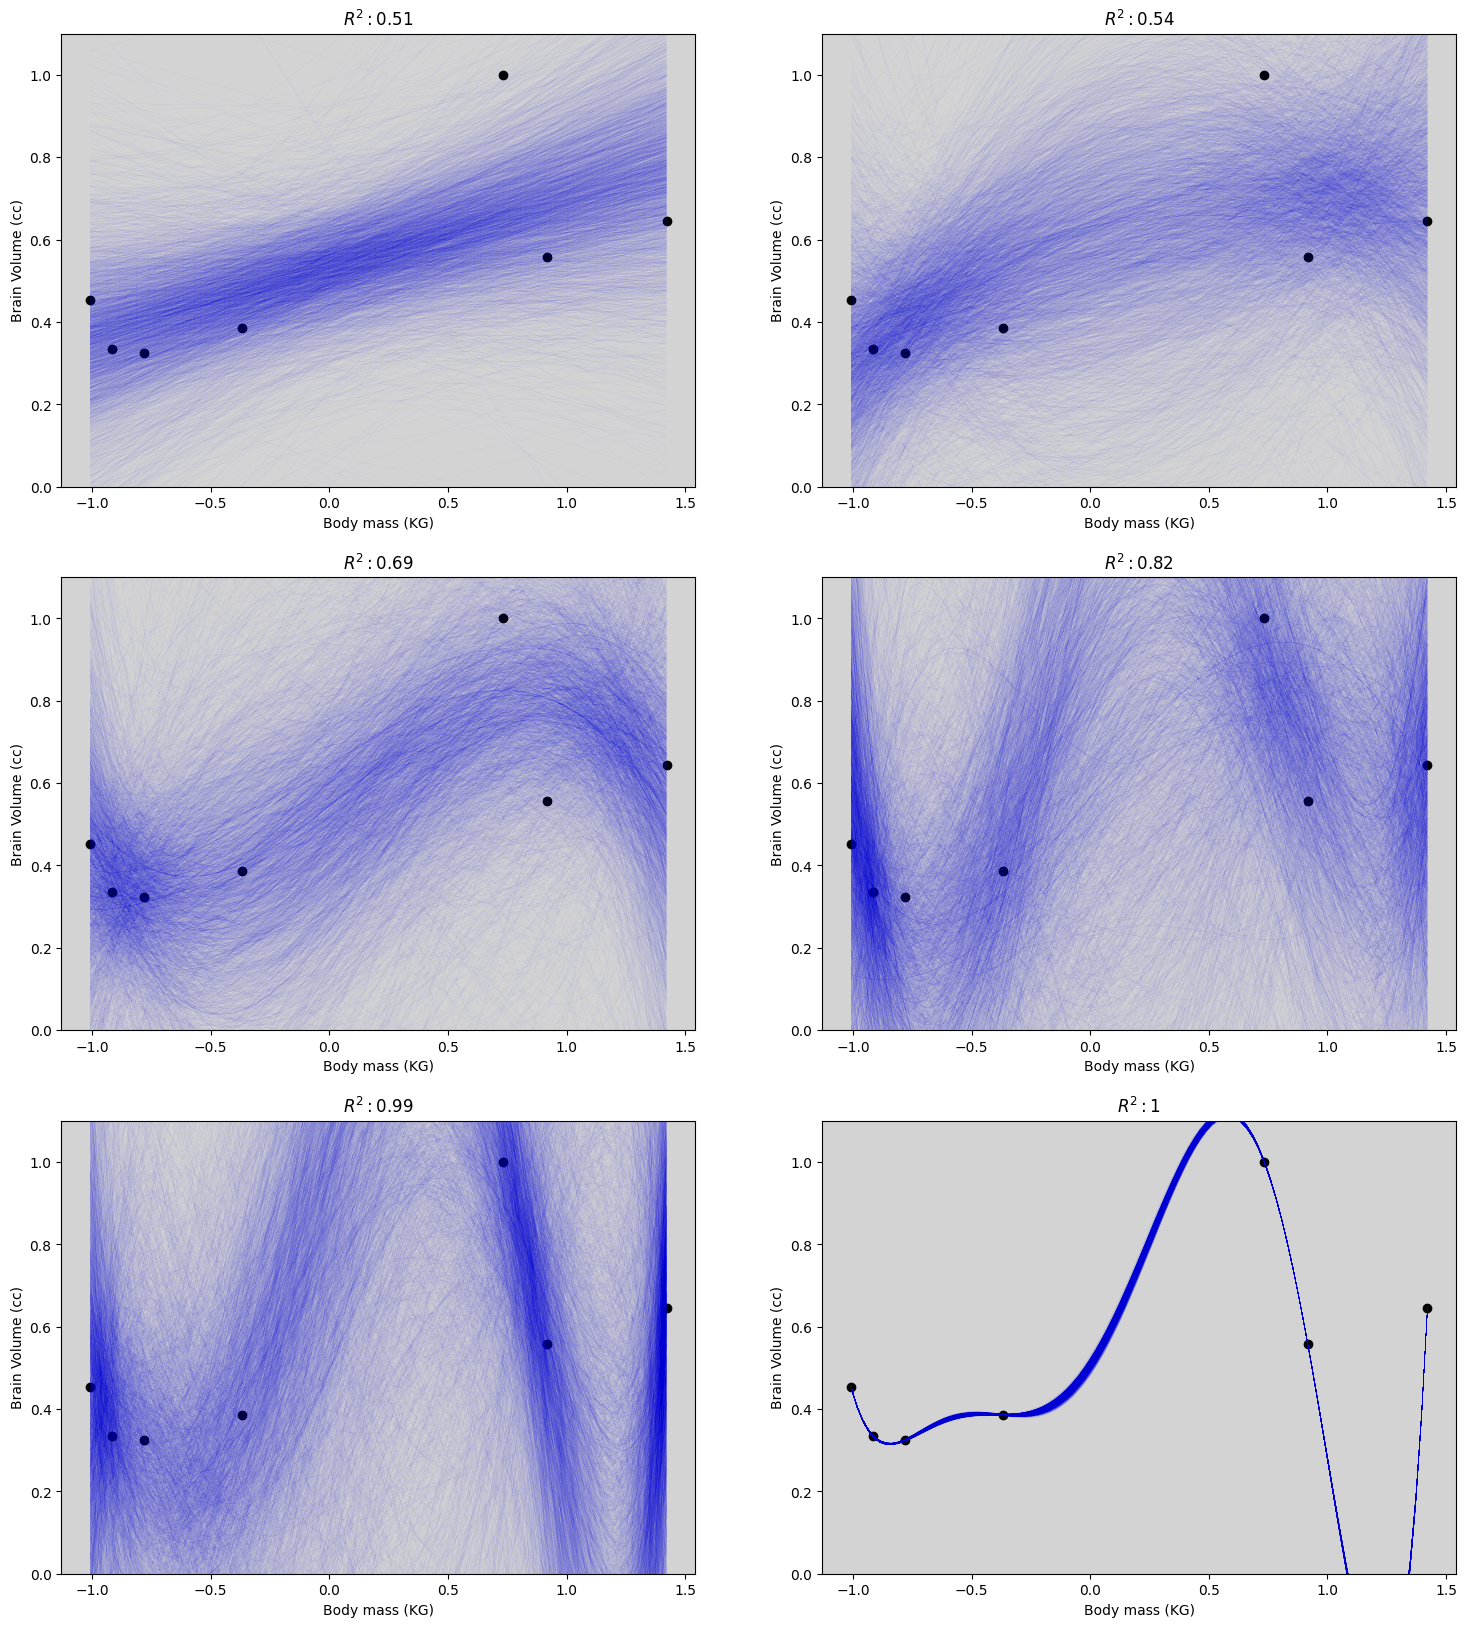

In [29]:
fig = plt.figure(figsize=(18, 20))

gs = GridSpec(nrows=3, ncols=2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(d.mass_std.values, d.brain_std.values, c='black')
ax1.plot(mass_seq, pp_1, c='blue', lw=0.01)
ax1.set_ylim(0, 1.1)
ax1.set_title('$R^2: 0.51$')
ax1.set_xlabel('Body mass (KG)')
ax1.set_ylabel('Brain Volume (cc)')

ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(d.mass_std.values, d.brain_std.values, c='black')
ax2.plot(mass_seq, pp_2, c='blue', lw=0.01)
ax2.set_ylim(0, 1.1)
ax2.set_title('$R^2: 0.54$')
ax2.set_xlabel('Body mass (KG)')
ax2.set_ylabel('Brain Volume (cc)')

ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(d.mass_std.values, d.brain_std.values, c='black')
ax3.plot(mass_seq, pp_3, c='blue', lw=0.01)
ax3.set_ylim(0, 1.1)
ax3.set_title('$R^2: 0.69$')
ax3.set_xlabel('Body mass (KG)')
ax3.set_ylabel('Brain Volume (cc)')

ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(d.mass_std.values, d.brain_std.values, c='black')
ax4.plot(mass_seq, pp_4, c='blue', lw=0.01)
ax4.set_ylim(0, 1.1)
ax4.set_title('$R^2: 0.82$')
ax4.set_xlabel('Body mass (KG)')
ax4.set_ylabel('Brain Volume (cc)')

ax5 = fig.add_subplot(gs[2, 0])
ax5.scatter(d.mass_std.values, d.brain_std.values, c='black')
ax5.plot(mass_seq, pp_5, c='blue', lw=0.01)
ax5.set_ylim(0, 1.1)
ax5.set_title('$R^2: 0.99$')
ax5.set_xlabel('Body mass (KG)')
ax5.set_ylabel('Brain Volume (cc)')

ax6 = fig.add_subplot(gs[2, 1])
ax6.scatter(d.mass_std.values, d.brain_std.values, c='black')
ax6.plot(mass_seq, pp_6, c='blue', lw=0.01)
ax6.set_ylim(0, 1.1)
ax6.set_title('$R^2: 1$')
ax6.set_xlabel('Body mass (KG)')
ax6.set_ylabel('Brain Volume (cc)')

plt.show()

### R Code 7.11 - Pag 201

In [30]:
d.brain_std

0    0.324444
1    0.334815
2    0.453333
3    0.385926
4    0.557037
5    0.645185
6    1.000000
Name: brain_std, dtype: float64

Deletando a linha $i=3$ do dataframe:

In [31]:
d_deleted_line_3 = d.brain_std.drop(3)
d_deleted_line_3

0    0.324444
1    0.334815
2    0.453333
4    0.557037
5    0.645185
6    1.000000
Name: brain_std, dtype: float64

### R Code 7.12 - Pag 206

**Entropia da informação**:  *A incerteza contida na distribuição de probabilidade* é a média do $log$ da probabilidade do evento.

In [32]:
def H(p):
    """Information Entropy
    H(p):= -sum(p_i * log(pi))
    """
    if not np.sum(p) == 1:
        print('ProbabilityError: This is not probability, its sum not equal to 1.')
    else:
        return - np.sum([p_i * np.log(p_i) if p_i > 0 else 0 for p_i in p])

In [33]:
p = (0.3, 0.7)  # (p_rain, p_sum)

H(p)

0.6108643020548935

A incerteza do clima de *Abu Dhabi* é menor, pois é pouco provável que chova.

In [34]:
p_AbuDhabi = (0.01, 0.99)  # (p_rain, p_sum)

H(p_AbuDhabi)

0.056001534354847345

In [35]:
p_3dim = (0.7, 0.15, 0.15)  # (p_1, p_2, p_3)

H(p_3dim)

0.818808456222877

### R Code 7.13 - pag 210

References:  

- https://stackoverflow.com/questions/49147905/how-to-extract-posterior-samples-of-log-likelihood-from-pystan

- https://mc-stan.org/docs/2_20/functions-reference/normal-distribution.html

**Obs**:

Here I learned to use the two blocks in stan: *transformed parameters* and *generated quantities*.

To calculate the **Deviance** it is necessary to make these changes. 

That's why I did all 6 estimates again with the calculations needed.

In [13]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta;
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[N] mu;
        mu = alpha + beta * body;
    }
    
    model {
        // Prioris
        alpha ~ normal(0.5, 1);
        beta ~ normal(0, 10);
        sigma ~ lognormal(0, 1);    
        
        // Likelihood
        brain ~ normal(mu, sigma);
    }
    
    generated quantities {
        vector[N] log_lik;
        vector[N] brain_hat;
        
        for (i in 1:N){
            log_lik[i] = normal_lpdf(brain[i] | mu[i], sigma);
            brain_hat[i] = normal_rng(mu[i], sigma);
        }
        
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_1 = stan.build(model, data=data)
samples_1 = posteriori_1.sample(num_chains=4, num_samples=1000)

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 

In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
            

Building: 13.4s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 13.9s
Building: 14.0s


/home/rodolpho/.cache/httpstan/4.9.1/models/ayrulifh/model_ayrulifh.cpp: In instantiation of ‘void model_ayrulifh_namespace::model_ayrulifh::transform_inits_impl(VecVar&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.9.1/models/ayrulifh/model_ayrulifh.cpp:492:69:   required from here
/home/rodolpho/.cache/httpstan/4.9.1/models/ayrulifh/model_ayrulifh.cpp:294:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  294 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/li

Building: 14.1s
Building: 14.2s
Building: 14.3s


/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl_ab(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_value<double>; T3 = stan::math::var_value<double>; T_z = stan::math::var_value<double>; ScalarT = stan::math::var_value<double>; TupleT = std::tuple<stan::math::var_value<double, void>, stan::math::var_value<double, void>, stan::math::var_value<double, void> >]’:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:205:78:   required from ‘TupleT stan::math::internal::grad_2F1_impl(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; bool calc_z = true; T1 = stan::math::var_va

Building: 14.4s
Building: 14.5s
Building: 14.6s
Building: 14.7s
Building: 14.8s
Building: 14.9s
Building: 15.0s
Building: 15.1s
Building: 15.2s
Building: 15.3s
Building: 15.4s
Building: 15.5s
Building: 15.6s
Building: 15.7s
Building: 15.8s
Building: 15.9s
Building: 16.0s
Building: 16.1s
Building: 16.2s
Building: 16.3s
Building: 16.4s
Building: 16.5s
Building: 16.6s
Building: 16.7s
Building: 16.8s
Building: 17.0s
Building: 17.1s
Building: 17.2s
Building: 17.3s
Building: 17.4s
Building: 17.5s
Building: 17.6s
Building: 17.7s
Building: 17.8s
Building: 17.9s
Building: 18.0s
Building: 18.1s
Building: 18.2s
Building: 18.3s
Building: 18.4s
Building: 18.5s
Building: 18.6s
Building: 18.7s
Building: 18.8s
Building: 18.9s
Building: 19.0s
Building: 19.1s
Building: 19.2s
Building: 19.3s
Building: 19.4s
Building: 19.5s
Building: 19.6s
Building: 19.7s
Building: 19.8s
Building: 19.9s
Building: 20.0s
Building: 20.2s
Building: 20.3s
Building: 20.4s
Building: 20.5s
Building: 20.6s
Building: 20.7s
Building

Building: 32.8s, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!


In [37]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[2];
        real<lower=0> sigma;
    }
    
    transformed parameters{
        vector[N] mu;
        mu = alpha + beta[1] * body + 
                     beta[2] * body^2;
    }
    
    model {
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:2){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 10);    
        
        // Likelihood
        brain ~ normal(mu, sigma);
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_2 = stan.build(model, data=data)
samples_2 = posteriori_2.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!


In [38]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[3];
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[N] mu;
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3;
    }
    
    model {                     
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:3){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 10);   
        
        // Likelihood
        brain ~ normal(mu, sigma);
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_3 = stan.build(model, data=data)
samples_3 = posteriori_3.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!


In [39]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[4];
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[N] mu;
        
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3 +
                     beta[4] * body^4;
    }
    
    model {
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:4){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 10); 
        
        // Likelihood
        brain ~ normal(mu, sigma);   
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_4 = stan.build(model, data=data)
samples_4 = posteriori_4.sample(num_chains=4, num_samples=1000)

Building: 0.1s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 

In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:110,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:7,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/e2neuzuk/model_e2neuzuk.cpp:2:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/generalized_inverse.hpp: In function ‘Eigen::Matrix<typename stan::value_type<T>::type, EigMat::ColsAtCo

Building: 7.3s
Building: 7.4s
Building: 7.5s
Building: 7.6s


In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:321,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:7,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/e2neuzuk/model_e2neuzuk.cpp:2:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/tail.hpp: In function ‘std::vector<T1> stan::math::tail(const std::vector<T1>&, size_t)’:
/home/rodolpho

Building: 7.7s
Building: 7.8s
Building: 7.9s
Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.5s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s


In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:32,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/e2neuzuk/model_e2neuzuk.cpp:2:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/cholesky_decompose.hpp: In lambda function:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/cholesky_decompose.hpp:83:11: warning: typedef ‘using Block_ = class Eigen::Block<Eigen::Mat

Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 9.9s


In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:74,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/e2neuzuk/model_e2neuzuk.cpp:2:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/generalized_inverse.hpp: In function ‘auto stan::math::generalized_inverse(const VarMat&)’:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/generalized_inverse.hpp:64:9: warning: typed

Building: 10.0s
Building: 10.1s


In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:121,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/e2neuzuk/model_e2neuzuk.cpp:2:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/lub_constrain.hpp: In function ‘auto stan::math::lub_constrain(const T&, const L&, const U&)’:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/lub_constrain.hpp:485:9: warning: typede

Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s


In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob/bernoulli_logit_glm_log.hpp:5,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob.hpp:10,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim.hpp:16,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:13,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/e2neuzuk/model_e2neuzuk.cpp:2:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/py

Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s


In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob/multi_normal_cholesky_log.hpp:6,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob.hpp:196,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim.hpp:16,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:13,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/e2neuzuk/model_e2neuzuk.cpp:2:
/home/rodolpho/Projects/rethinking/RETHINKING/lib

Building: 12.0s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.7s


In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob/ordered_logistic_log.hpp:5,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob.hpp:248,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim.hpp:16,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:13,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/e2neuzuk/model_e2neuzuk.cpp:2:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/pyth

Building: 12.8s
Building: 12.9s
Building: 13.0s


In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/indexing.hpp:7,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:17,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/e2neuzuk/model_e2neuzuk.cpp:2:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/indexing/assign_varmat.hpp: In function ‘void stan::model::assign(Mat1&&, const Mat2&, const char*, const stan::model::index_multi&, const stan::model::index_multi&)’:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/indexing/assign_varmat.hpp:329:9: warning: typedef ‘using pair_type = struct std::pair<int, std::vector<int, stan::math::arena_allocator<int> > >’ locally defined but not used [-Wunused-local-typedefs]
  329 |   using pair_type = std::pair<int, a

Building: 13.1s
Building: 13.2s
Building: 13.3s


/home/rodolpho/.cache/httpstan/4.5.0/models/e2neuzuk/model_e2neuzuk.cpp: In member function ‘void model_e2neuzuk_namespace::model_e2neuzuk::transform_inits_impl(const stan::io::var_context&, VecI&, VecVar&, std::ostream*) const’:
/home/rodolpho/.cache/httpstan/4.5.0/models/e2neuzuk/model_e2neuzuk.cpp:298:11: warning: typedef ‘using local_scalar_t__ = double’ locally defined but not used [-Wunused-local-typedefs]
  298 |     using local_scalar_t__ = double;
      |           ^~~~~~~~~~~~~~~~


Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 13.9s


/home/rodolpho/.cache/httpstan/4.5.0/models/e2neuzuk/model_e2neuzuk.cpp: In instantiation of ‘void model_e2neuzuk_namespace::model_e2neuzuk::transform_inits_impl(const stan::io::var_context&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_std_vector_t<T>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.5.0/models/e2neuzuk/model_e2neuzuk.cpp:470:68:   required from here
/home/rodolpho/.cache/httpstan/4.5.0/models/e2neuzuk/model_e2neuzuk.cpp:304:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  304 |       int pos__;
      |           ^~~~~


Building: 14.0s
Building: 14.1s
Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.5s
Building: 14.6s
Building: 14.7s
Building: 14.8s
Building: 14.9s
Building: 15.0s
Building: 15.1s
Building: 15.2s
Building: 15.3s
Building: 15.4s
Building: 15.6s
Building: 15.7s
Building: 15.8s
Building: 15.9s
Building: 16.0s
Building: 16.1s
Building: 16.2s
Building: 16.3s
Building: 16.4s
Building: 16.5s
Building: 16.6s
Building: 16.7s
Building: 16.8s
Building: 16.9s
Building: 17.0s
Building: 17.1s
Building: 17.2s
Building: 17.3s
Building: 17.4s
Building: 17.5s
Building: 17.6s
Building: 17.7s
Building: 17.8s
Building: 17.9s
Building: 18.0s
Building: 18.1s
Building: 18.2s
Building: 18.3s


In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/err/check_not_nan.hpp:5,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/err/check_2F1_converges.hpp:5,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/err.hpp:4,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/core.hpp:53,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:8,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp

Building: 18.4s
Building: 18.5s
Building: 18.6s
Building: 18.7s
Building: 18.8s
Building: 18.9s
Building: 19.0s
Building: 19.1s
Building: 19.2s
Building: 19.3s
Building: 19.4s
Building: 19.6s
Building: 19.7s
Building: 19.8s
Building: 19.9s
Building: 20.0s
Building: 20.1s
Building: 20.2s
Building: 20.3s
Building: 20.4s
Building: 20.5s
Building: 20.6s
Building: 20.7s
Building: 20.8s
Building: 20.9s
Building: 21.0s
Building: 21.1s
Building: 21.2s
Building: 21.3s
Building: 21.4s
Building: 21.5s
Building: 21.6s
Building: 21.7s
Building: 21.8s
Building: 21.9s
Building: 22.0s
Building: 22.1s
Building: 22.2s
Building: 22.3s
Building: 22.4s
Building: 22.5s
Building: 22.6s
Building: 22.7s
Building: 22.8s
Building: 22.9s
Building: 23.0s
Building: 23.1s
Building: 23.2s
Building: 23.4s
Building: 23.5s
Building: 23.6s
Building: 23.7s
Building: 23.8s
Building: 23.9s
Building: 24.0s
Building: 24.1s
Building: 24.2s
Building: 24.3s
Building: 24.4s
Building: 24.5s
Building: 24.6s
Building: 24.7s
Building

Building: 34.3s, done.
Sampling:   0%
Sampling:  10% (800/8000)
Sampling:  35% (2800/8000)
Sampling:  60% (4800/8000)
Sampling:  85% (6800/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!


In [53]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[5];
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[N] mu;
        
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3 +
                     beta[4] * body^4 +
                     beta[5] * body^5;
    }
    
    model {          
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:5){
            beta[j] ~ normal(0, 10);
        }
        sigma ~ lognormal(0, 10);    
        
        // Likelihood
        brain ~ normal(mu, sigma);
    }
    
    generated quantities {
        vector[N] log_lik;
        vector[N] brain_hat;
        
        for (i in 1:N){
            log_lik[i] = normal_lpdf(brain[i] | mu[i], sigma);
            brain_hat[i] = normal_rng(mu[i], sigma);
        }
        
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_5 = stan.build(model, data=data)
samples_5 = posteriori_5.sample(num_chains=4, num_samples=1000)

Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s
Building: 

In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
            

Building: 13.8s
Building: 13.9s
Building: 14.0s
Building: 14.1s
Building: 14.2s


/home/rodolpho/.cache/httpstan/4.9.1/models/n3apyys5/model_n3apyys5.cpp: In instantiation of ‘void model_n3apyys5_namespace::model_n3apyys5::transform_inits_impl(VecVar&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.9.1/models/n3apyys5/model_n3apyys5.cpp:549:69:   required from here
/home/rodolpho/.cache/httpstan/4.9.1/models/n3apyys5/model_n3apyys5.cpp:340:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  340 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~


Building: 14.3s
Building: 14.4s


In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
            

Building: 14.5s
Building: 14.6s
Building: 14.7s
Building: 14.8s
Building: 14.9s
Building: 15.0s
Building: 15.1s
Building: 15.2s
Building: 15.3s
Building: 15.4s
Building: 15.5s
Building: 15.6s
Building: 15.7s
Building: 15.8s
Building: 15.9s
Building: 16.0s
Building: 16.1s
Building: 16.2s
Building: 16.3s
Building: 16.4s
Building: 16.6s
Building: 16.7s
Building: 16.8s
Building: 16.9s
Building: 17.0s
Building: 17.1s
Building: 17.2s
Building: 17.3s
Building: 17.4s
Building: 17.5s
Building: 17.6s
Building: 17.7s
Building: 17.8s
Building: 17.9s
Building: 18.0s
Building: 18.1s
Building: 18.2s
Building: 18.3s
Building: 18.4s
Building: 18.5s
Building: 18.6s
Building: 18.7s
Building: 18.8s
Building: 18.9s
Building: 19.0s
Building: 19.1s
Building: 19.2s
Building: 19.3s
Building: 19.4s
Building: 19.5s
Building: 19.6s
Building: 19.7s
Building: 19.8s
Building: 19.9s
Building: 20.0s
Building: 20.2s
Building: 20.3s
Building: 20.4s
Building: 20.5s
Building: 20.6s
Building: 20.7s
Building: 20.8s
Building

Building: 35.8s, done.
Messages from stanc:
Warning in '/tmp/httpstan_3z4e3n3q/model_n3apyys5.stan', line 10, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:   4% (300/8000)
Sampling:   9% (700/8000)
Sampling:  15% (1200/8000)
Sampling:  22% (1800/8000)
Sampling:  44% (3500/8000)
Sampling:  64% (5100/8000)
Sampling:  82% (6600/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  G

In [41]:
model = """
    data {
        int N;
        vector[N] brain;
        vector[N] body;
    }
    
    parameters {
        real alpha;
        real beta[6];
    }
    
    transformed parameters {
        vector[N] mu;
        
        mu = alpha + beta[1] * body   + 
                     beta[2] * body^2 +
                     beta[3] * body^3 +
                     beta[4] * body^4 +
                     beta[5] * body^5 +
                     beta[6] * body^6;
    }
    
    model {          
        // Prioris
        alpha ~ normal(0.5, 1);
        for (j in 1:6){
            beta[j] ~ normal(0, 10);
        }    
        
        // Likelihood
        brain ~ normal(mu, 0.001);
    }
    
    generated quantities {
        vector[N] log_ll_y;
        
        for (i in 1:N){
            log_ll_y[i] = normal_lpdf(brain[i] | mu, 0.001);
        }
    }
"""

data = {
    'N': len(d.brain_std),
    'brain': d.brain_std.values,
    'body': d.mass_std.values,
}

posteriori_6 = stan.build(model, data=data)
samples_6 = posteriori_6.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_z04lu0w1/model_ax74r77n.stan', line 32, column 27: Argument 0.001 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   6% (500/8000)
Sampling:  16% (1300/8000)
Sampling:  22% (1800/8000)
Sampling:  29% (2300/8000)
Sampling:  48% (3800/8000)
Sampling:  62% (5000/8000)
Sampling:  81% (6500/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition 

In [42]:
def lppd(samples, outcome, std_residuals=True):
    """ Calculate the LOG-POINTWISE-PREDICTIVE-DENSITY
    
    samples : stan
        Sampler results of fit posteriori. 
        Need 'mu' already computed.
    
    outcome : list
        List with outcomes the original data.
        
    std_residuals : booleans
        Compute lppd using std of the residuals 
    """
    mu = samples['mu']
    N = len(outcome)
    K = np.shape(mu)[1]  # Qty samples (mu) sampled from posteriori

    outcome = outcome.reshape(-1, 1)

    if std_residuals:
        sigma = (np.sum((mu - outcome)**2, 0) / N)**0.5    
    else:
        sigma = samples['sigma'].flatten()
        
    lppd = np.empty(N, dtype=float)
       
    for i in range(N):
        log_posteriori_predictive = stats.norm.logpdf(outcome[i], mu[i], sigma)

        lppd[i] = np.log(np.sum(np.exp(log_posteriori_predictive))) - np.log(K)
    
    return lppd    

### R Code 7.15

Like the book and the [this](https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_07.ipynb) one the values here have slight differeces. 

*Need review calculations - pag 211 - 2ed*

In [43]:
lppd_lm = []

lppd_lm.append(np.sum(lppd(samples_1, d.brain_std.values, std_residuals=True)))
lppd_lm.append(np.sum(lppd(samples_2, d.brain_std.values, std_residuals=True)))
lppd_lm.append(np.sum(lppd(samples_3, d.brain_std.values, std_residuals=True)))
lppd_lm.append(np.sum(lppd(samples_4, d.brain_std.values, std_residuals=True)))
lppd_lm.append(np.sum(lppd(samples_5, d.brain_std.values, std_residuals=True)))
lppd_lm.append(np.sum(lppd(samples_6, d.brain_std.values, std_residuals=True)))

lppd_lm

[1.9841584645143158,
 1.9260686637867952,
 2.1635243626894987,
 3.2122508926339695,
 8.195738593753036,
 40.137951546890044]

In [1]:
import arviz as az
# ArviZ ships with style sheets!
# https://python.arviz.org/en/stable/examples/styles.html#example-styles
az.style.use("arviz-darkgrid")

In [14]:
data = az.from_pystan(
    posterior=samples_5,
    posterior_predictive="brain_hat",
    observed_data=data,
    log_likelihood={"brain": "log_lik"},
)

data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats

In [54]:
data5 = az.from_pystan(
    posterior=samples_5,
    posterior_predictive="brain_hat",
    observed_data=data,
    log_likelihood={"brain": "log_lik"},
)

data5

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats

In [56]:
y_true = d.brain_std.values
y_pred = data5.posterior_predictive.stack(sample=("chain", "draw"))["brain_hat"].values.T
az.r2_score(y_true, y_pred)

r2        0.690085
r2_std    0.168347
dtype: float64

In [58]:
aa = az.loo(samples_5, pointwise=True)

/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: title={'center': 'samples_1 - samples_5'}, ylabel='ELPD difference'>

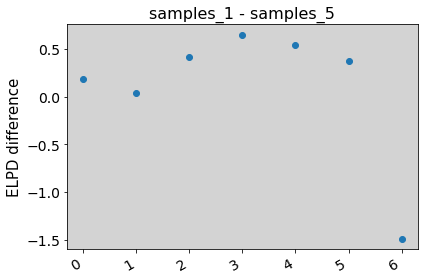

In [64]:
az.plot_elpd({'samples_1':samples_1, 'samples_5': samples_5}, xlabels=True)

In [39]:
aaa = data.posterior_predictive.brain_hat[0].values
np.log(np.sum(np.exp(aaa.T), 1)) - np.log(1000)

array([0.45999081, 0.4457565 , 0.42092447, 0.53410182, 0.73808534,
       0.82408576, 0.70316885])

### R Code 7.16

Just using Rethinking Packages - pag 213

### R Code 7.17

Just using Rethinking Packages - Pag 213

### R Code 7.18

Just using Rethinking Packages - pag 214

-------